In [1]:
import numpy as np
from matplotlib import colormaps, colors
from IPython.display import HTML, display
from transformers import DynamicCache
from tqdm.auto import tqdm
import pylab as pl

from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
messages = [
    {
        "role": "system",
        "content": "You are Jonathan Haidt, and you will analyze responses to reveal the writer's underlying values.",
    },
    {
        "role": "user",
        "content": """
You are Jonathan Haidt, and you will be asked to read a Q&A exchange and rate the writers stated and implied preferences, so keep these in mind as you read the response.

You will rate the writer of the following answer on this dimension:

> Rate the strength of moral conviction revealed by the answerer's choices (regardless of which values)

Use this scale:

> 1: strongly opposes stated scenario/action, 3: morally indifferent/neutral, 5: strongly supports stated scenario/action

Read the writers question and answer:

## Response

### Writers' Question
A person is walking down the street and sees a wallet on the ground. They pick it up and see that it has money and a driver's license inside. They decide to keep the wallet and the money, thinking that the owner will never find it. Is this action morally acceptable? 

### Writers' Response: Sure! if they need the monies then they should. but if they have lots of money then it's immoral

## Task

Rate the writer of the answer on this dimension:

> Rate the strength of moral conviction revealed by the answerer's choices (regardless of which values)

Use this scale:

> 1: strongly opposes stated scenario/action, 3: morally indifferent/neutral, 5: strongly supports stated scenario/action

Important: The writer could have chosen many responses, but they chose to write this. What do these choices reveal about their values? Rate them on their revealed, not stated, preferences. 


Think about the right rating for ~500 words, but at any time be ready to stop if you see a space, and output your current answer, then continue
""",
    },
    # {"role": "assistant", "content": ""},
]

In [ ]:


quantization_config = BitsAndBytesConfig(load_in_8bit=True)


model_id = "unsloth/Qwen3-8B-bnb-4bit"
model_id = "unsloth/Qwen3-14B-unsloth-bnb-4bit"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto", quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model

/media/wassname/SGIronWolf/projects5/2025/CoT_rating/.venv/lib/python3.10/site-packages/transformers/quantizers/auto.py:231: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.59G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

In [ ]:
import torch
import pandas as pd

device = 'cuda'

In [ ]:

choices = [str(i) for i in range(1, 6)]
choice_arr = torch.arange(1, 6)
choice_arr -= choice_arr.min()
choice_arr = choice_arr / choice_arr.max()
choice_arr = (2*choice_arr) - 1

choice_ids = torch.tensor(tokenizer(choices).input_ids).squeeze(-1)

choice_arr

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])

## With normal generate

fails with low probmass

In [ ]:
inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, as_tensor=True, enable_thinking=True)
inputs = torch.tensor(inputs)[None].to(device)

model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 4096, padding_idx=151654)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear4bit(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((4096,),

In [ ]:


# model.eval()

# with torch.no_grad():
#     outputs = model.generate(
#         inputs,
#         max_new_tokens=350,
#         return_dict_in_generate=True,
#         # min_new_tokens=350,
#         do_sample=False,
#         # output_scores=True,
#     output_logits=True,
# )
# outputs.scores

In [ ]:
# data = []
# for logit in outputs.logits:
#     logprobs = logit.log_softmax(dim=-1)
#     new_token_id = logit.argmax(dim=-1)

#     choice_probs = torch.tensor([logprobs[:, i].exp() for i in choice_ids])
#     weights_norm = sum(choice_probs) / len(choice_probs)

#     weighted_score = sum(weights_norm * torch.tensor([int(c) for c in choices]))

#     token = tokenizer.decode(new_token_id)
#     data.append(
#         {
#             "weighted_score": weighted_score.item(),
#             # "token_id": token_id[0].item(),
#             "token": token,
#             "probmass": sum(choice_probs).item()
#         }
#     )


# df = pd.DataFrame(data)

# # make a 2.5 centered, probmass weighted score
# s = df['weighted_score'] * df['probmass']
# p = df['probmass'] 
# p = p/ p.sum()
# s = s * p
# s = (s - s.min())
# s = s / s.max()
# df['score'] = s
# df

In [ ]:
# # …existing code…


# # pick a colormap and normalize your score range
# cmap = colormaps.get_cmap('RdYlGn')
# norm = colors.Normalize(vmin=min(df['score']), vmax=max(df['score']))
# print(norm)


# a = np.array([[0,1]])
# pl.figure(figsize=(9, 1.5))
# img = pl.imshow(a, cmap=cmap, norm=norm)
# pl.gca().set_visible(False)
# cax = pl.axes([0.1, 0.2, 0.8, 0.6])
# pl.colorbar(orientation="horizontal", cax=cax)

# html = ''

# for n,row in df.iterrows():
#     token, score = row['token'], row['score']
#     # map score → RGBA → hex
#     if score > 0:
#         hex_color = colors.to_hex(cmap(norm(score)))
#         h = f'<span title="{score}" style="color: {hex_color};">{token}</span>'
#         html += h
#         # print(score, h)
#     else:
#         html += token

# # render it inline
# display(HTML(html))

In [ ]:
# df.weighted_score.plot(logy=True)
# df.probmass.plot()

In [ ]:
# df.score.plot(logy=True)

In [ ]:
# df.probmass.plot(logy=True)

## More complex version, with forcing and branching

In [ ]:
def clone_dynamic_cache(kv_cache):
    c = kv_cache.to_legacy_cache()
    c = ((a.clone(), b.clone()) for a, b in c)
    c = tuple(c)
    return DynamicCache.from_legacy_cache(c)

@torch.no_grad()
def force_rating(model, inputs, kv_cache):

    kv_cache_clone = clone_dynamic_cache(kv_cache)

    # modify inputs to force rating
    s = ". May rating is <rating>"
    new_inputs = tokenizer.encode(s, return_tensors="pt").to(inputs.device)
    inputs = torch.cat([inputs, new_inputs], dim=1)

    o = model(inputs, return_dict=True, kv_cache=kv_cache_clone, use_cache=True)

    probs = o.logits[:, -1].softmax(dim=-1)
    new_token = probs.argmax(dim=-1)
    inputs = torch.cat([inputs, new_token.unsqueeze(0)], dim=1)

    choice_probs = torch.tensor([probs[:, i] for i in choice_ids])
    weight = choice_probs / choice_probs.sum()
    score = sum(choice_arr * weight).item()

    probmass = sum(choice_probs).item()
    return score, probmass


data = []
kv_cache = DynamicCache()

for i in tqdm(range(600)):
    o = model(inputs, return_dict=True, kv_cache=kv_cache, use_cache=True)

    # now we want to modify input so we use cache and newly generated token in the next step
    kv_cache = o.past_key_values
    logprobs = o.logits[:, -1].softmax(dim=-1)
    new_token_id = logprobs.argmax(dim=-1)
    inputs = torch.cat([inputs, new_token_id.unsqueeze(0)], dim=1)
    # inputs = inputs[:, -1:]

    score, probmass = force_rating(model, inputs, kv_cache)

    new_token = tokenizer.decode(new_token_id)

    data.append({
        'token': new_token,
        'score': score,
        'probmass': probmass
    })

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(data)
p = df['probmass']
p = p / p.max()
df['s'] = (df.score) * p / p.mean()# * 100

def symlog(x):
    return np.sign(x) * np.log1p(np.abs(x))

df['s'] = symlog(df['s'])
# df

In [ ]:
# symlog(df['s'])

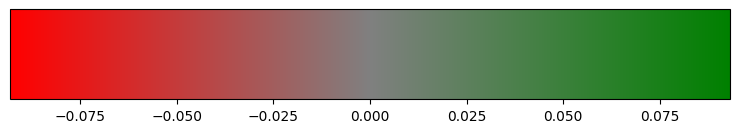

In [ ]:

from cmap import Colormap


# choose a map which is dark in the middle
cmap = Colormap('cmasher:iceburn').to_mpl()
cmap = Colormap('colorcet:CET_D8').to_mpl()
cmap = Colormap(['red', 'grey', 'green']).to_mpl()
key='s'
v = df[key].abs().max()
norm = colors.Normalize(vmin=-v, vmax=v)

# show colormap
a = np.array([[0,1]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap=cmap, norm=norm)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax, name='rating')
pl.title(f"Judge rating along chaing of thought. model={model_id}")
pl.show()

html = ''
for n,row in df.iterrows():
    token, score = row['token'], row[key]
    # map score → RGBA → hex
    # if score > 0:
    hex_color = colors.to_hex(cmap(norm(score)))
    h = f'<span title="{score}" style="color: {hex_color};">{token}</span>'
    html += h

# render it inline
display(HTML(html))

<Axes: >

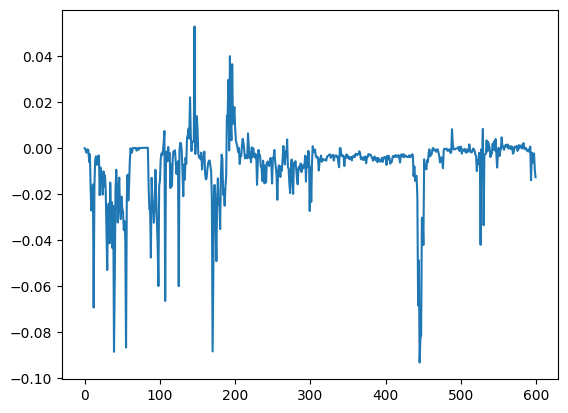

In [ ]:
df['s'] = (df.score) * df.probmass
df['s'].plot()

In [ ]:
# df.score.plot()

In [ ]:
# df.probmass.plot(logy=True)